In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/pic2"

/content/drive/MyDrive/pic2


In [ ]:
## DACON에서 대회 준비중인 수정전 파일입니다.
import tensorflow as tf
import os
import numpy as np
import PIL

from PIL import Image
from glob import glob

In [ ]:
root = 'train/'
training_images = []
training_labels = []

for filename in glob(root +"*"):
    for img in glob(filename + "/*.jpg"):
        an_img = PIL.Image.open(img)
        img_array = np.array(an_img)
        training_images.append(img_array)
        label = filename.split('/')[1]
        training_labels.append(label)
  
training_images = np.array(training_images)
training_labels = np.array(training_labels)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
training_labels= le.fit_transform(training_labels)
training_labels = training_labels.reshape(-1,1)

print(training_images.shape)
print(training_labels.shape)

(50000, 32, 32, 3)
(50000, 1)


In [ ]:
root2 = 'test/'
test_images = []
test_idx = []

flist = sorted(glob(root2 + '*.jpg'))

for filename in flist:
    an_img = PIL.Image.open(filename)
    img_array = np.array(an_img) 
    test_images.append(img_array) 
    label = filename.split('/')[1] 
    test_idx.append(label)
    
test_images = np.array(test_images)

print(test_images.shape)
print(test_idx[0:5])


(10000, 32, 32, 3)
['0000.jpg', '0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg']


[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],

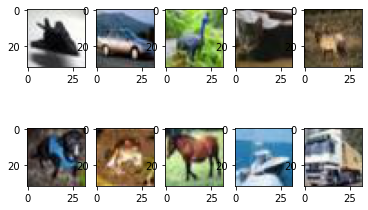

In [ ]:
import matplotlib.pyplot as plt

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(training_images[i*5000])
    print(training_labels[i*5000], end=",")
plt.show()

In [ ]:
print(training_images.shape)
print(training_labels.shape)

(50000, 32, 32, 3)
(50000, 1)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)

image_generator = ImageDataGenerator(
    rotation_range=45,
    brightness_range = [0.7, 1.0],
    zoom_range=0.4,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip = True,
    vertical_flip = False
)

In [ ]:
augment_size=50000

np.random.seed(42)

mask = np.random.randint(training_images.shape[0], size=augment_size)
training_image2 = training_images[mask].copy()
training_labels2 = training_labels[mask].copy()

In [ ]:
training_image2 = image_generator.flow(training_image2, np.zeros(augment_size), batch_size=augment_size, shuffle=False, seed = 42).next()[0]

training_images = np.concatenate((training_images, training_image2))
training_labels = np.concatenate((training_labels, training_labels2))

In [ ]:
X_train = training_images / 255.0
X_test = test_images/255.0

In [ ]:
index = np.arange(X_train.shape[0])
np.random.shuffle(index)
features = X_train[index]
label = training_labels[index]

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), 
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), 
    tf.keras.layers.BatchNormalization(), 
    
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), 
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), 
    tf.keras.layers.BatchNormalization(), 
    
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), 
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), 
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), 
    tf.keras.layers.BatchNormalization(), 
    
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), 
    
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), 
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), 
    tf.keras.layers.BatchNormalization(), 
    
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), 
    
    tf.keras.layers.GlobalAveragePooling2D(), 

    tf.keras.layers.Dense(256, activation = 'relu'), 
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(10, activation = 'softmax') 
])

In [ ]:
learning_rate = 0.001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#코랩 메모리 용량 부족으로 도중에 꺼졌습니다.
#그래서 에포크를 줄이고 학습시켜보니 초반보다 정확도가 3퍼 높게 나왔습니다.
from sklearn.model_selection import KFold

kfold = KFold(n_splits = 3)

n_iter = 0

for train_index, validataion_index in kfold.split(features):
    X_train , X_valid = features[train_index] , features[validataion_index]
    y_train , y_valid = label[train_index] , label[validataion_index]
    model1 = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=128, verbose = 2)
    n_iter += 1

Epoch 1/30
521/521 - 60s - loss: 1.6941 - accuracy: 0.3984 - val_loss: 2.0988 - val_accuracy: 0.3335 - 60s/epoch - 115ms/step
Epoch 2/30
521/521 - 46s - loss: 1.2782 - accuracy: 0.5576 - val_loss: 1.2119 - val_accuracy: 0.5771 - 46s/epoch - 89ms/step
Epoch 3/30
521/521 - 46s - loss: 1.0484 - accuracy: 0.6447 - val_loss: 1.0589 - val_accuracy: 0.6368 - 46s/epoch - 89ms/step
Epoch 4/30
521/521 - 51s - loss: 0.8867 - accuracy: 0.7027 - val_loss: 0.9534 - val_accuracy: 0.6716 - 51s/epoch - 97ms/step
Epoch 5/30
521/521 - 47s - loss: 0.7449 - accuracy: 0.7484 - val_loss: 1.0082 - val_accuracy: 0.6756 - 47s/epoch - 90ms/step
Epoch 6/30
521/521 - 51s - loss: 0.6201 - accuracy: 0.7918 - val_loss: 0.9362 - val_accuracy: 0.6997 - 51s/epoch - 97ms/step
Epoch 7/30
521/521 - 47s - loss: 0.4984 - accuracy: 0.8317 - val_loss: 0.9135 - val_accuracy: 0.7168 - 47s/epoch - 90ms/step
Epoch 8/30
521/521 - 51s - loss: 0.3984 - accuracy: 0.8653 - val_loss: 0.9635 - val_accuracy: 0.7240 - 51s/epoch - 97ms/step

KeyboardInterrupt: ignored

In [ ]:
import pandas as pd

sample_submission = pd.read_csv("/content/drive/MyDrive/pic2/sample_submission.csv")

sample_submission.target = pred_class
sample_submission.to_csv("submit.csv",index=False)

In [ ]:
sample_submission.head()

,id,target
0,0000.jpg,horse
1,0001.jpg,bird
2,0002.jpg,airplane
3,0003.jpg,bird
4,0004.jpg,airplane
